# **Program Functions** <a id="program-functions"></a>

This section outlines the main functions and features of the program. It provides a detailed description of what the program does and how it performs its tasks. Key features may include:

- Core functionality
- Additional features
- Any special capabilities or tools integrated into the program

In [1]:
# need tp install
%pip install lmfit

Note: you may need to restart the kernel to use updated packages.


In [2]:
# required packages
import os
from datetime import datetime
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.signal import find_peaks
import numpy as np
from decimal import Decimal
from lmfit import Parameters, Minimizer, Model
import xml.etree.ElementTree as eT

1. **os**: This module provides functions to interact with the operating system. It allows manipulation of file paths, accessing environment variables, etc.

2. **datetime**: This module provides classes for manipulating dates and times. It supports conversion, comparison, and operations with date and time formats.

3. **sys**: This module provides functions and variables to interact with the Python interpreter. It allows access to command-line arguments and modification of interpreter settings.

4. **pandas (pd)**: This library is used for data manipulation and analysis. It facilitates handling tabular data structures, offering features like reading, writing, filtering, aggregating, and merging data.

5. **matplotlib.pyplot (plt)**: This library is used for data visualization. It provides functions to create various types of charts such as line plots, bar charts, scatter plots, etc., and allows customization of styles and labels.

6. **matplotlib.ticker.FuncFormatter**: This class in matplotlib allows formatting axis labels using custom functions. It enables users to format axis labels based on specific requirements.

7. **scipy.signal.find_peaks**: This function from the scipy library is used in signal processing to find peaks in a given array. It is useful for analyzing patterns or specific structures in signals.

8. **numpy (np)**: This library is essential for scientific computing. It provides support for multidimensional arrays and matrix operations, offering powerful numerical computing and data manipulation capabilities.

9. **decimal.Decimal**: This class provides support for decimal floating point arithmetic. It is used when precise and predictable arithmetic is required, especially in financial and other exact computations.

10. **lmfit.Parameters, lmfit.Minimizer, lmfit.Model**: These classes from the lmfit library are used for parameter optimization. They allow fitting models to data and estimating optimized parameters based on the given data.

11. **xml.etree.ElementTree (eT)**: This built-in library is used for parsing and manipulating XML documents. It manages XML elements in a tree structure, allowing traversal and manipulation of XML data.


## **setting.py**

In [3]:
def set_up(directory0, directory1, directory2, current_directory, testsite, xlsx_file, graph_image):
    base_directory = os.path.join(current_directory, 'dat', directory0)
    data_dict = create_data_frame()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    print (timestamp)
    if directory1.lower() == 'all':
        if not os.path.isdir(base_directory):
            print(f"The base directory {base_directory} does not exist.")
        else:
            for dir1 in os.listdir(base_directory):
                dir1_path = os.path.join(base_directory, dir1)
                if not os.path.isdir(dir1_path):
                    print(f"The directory {dir1_path} does not exist or is not a directory.")
                    continue
                for dir12 in os.listdir(dir1_path):
                    xml_directory = os.path.join(dir1_path, dir12)
                    if os.path.isdir(xml_directory):
                        main(directory0, dir1, dir12, current_directory, data_dict, testsite, graph_image, timestamp)
    else:
        if directory2.lower() == 'all':
            base_directory2 = os.path.join(current_directory, 'dat', directory0, directory1)
            if not os.path.isdir(base_directory2):
                print(f"The base directory {base_directory2} does not exist.")
            else:
                for dir2 in os.listdir(base_directory2):
                    xml_directory = os.path.join(base_directory2, dir2)
                    if os.path.isdir(xml_directory):
                        main(directory0, directory1, dir2, current_directory, data_dict, testsite, graph_image, timestamp)
        else:
            main(directory0, directory1, directory2, current_directory, data_dict, testsite, graph_image, timestamp)

    if xlsx_file:
        output_directory = os.path.join(current_directory, 'res',timestamp, 'xlsx')
        os.makedirs(output_directory, exist_ok=True)
        xlsx_file_path = os.path.join(output_directory, f'analysis_result.xlsx')
        save_data_frame(data_dict, xlsx_file_path)
    print('Data analysis is complete.')


## Function: **set_up**

### Explanation
- **Purpose**: Sets up and executes data processing and plotting for multiple directories of XML files based on provided parameters.
- **Parameters**:
  - `directory0`, `directory1`, `directory2`: Subdirectories within `current_directory` where XML files are located. They may be specified as 'all' to iterate over all subdirectories.
  - `current_directory`: Root directory containing subdirectories where XML files reside.
  - `testsite`: List of test site names used to filter XML files.
  - `xlsx_file`: Boolean flag indicating whether to save the processed data as an Excel file.
  - `graph_image`: Boolean flag indicating whether to save generated plots as images.

- **Operation**:
  - **Base Directory Setup**: Constructs `base_directory` based on `directory0` and initializes an empty `data_dict` using `create_data_frame`.
  - **Timestamp Generation**: Generates a timestamp (`timestamp`) for organizing output directories and files.
  - **Directory Iteration**:
    - If `directory1` is 'all', iterates over all subdirectories (`dir1`) within `base_directory`.
      - Checks if each `dir1` exists and is a directory.
      - Iterates over subdirectories (`dir12`) within each `dir1` to construct `xml_directory`.
      - Calls `main` function to process XML files in `xml_directory` for each valid directory.
    - If `directory2` is 'all', constructs `base_directory2` and iterates over all subdirectories (`dir2`) within it.
      - Calls `main` function to process XML files in each valid `xml_directory`.
    - Otherwise, directly calls `main` function to process XML files in the specified `directory0`, `directory1`, and `directory2`.
  - **Save Data as Excel**: If `xlsx_file` is `True`, creates an output directory (`output_directory`) and saves `data_dict` as an Excel file (`analysis_result.xlsx`) using `save_data_frame`.

- **Return Value**: None. The function operates by side effects, processing XML files, generating plots, and saving data as specified.


## **main.py**

In [4]:
def main(directory0, directory1, directory2, current_directory, data_dict, testsite, graph_image, timestamp):
    xml_files, xml_directory = parse_xml_files(directory0, directory1, directory2, current_directory,testsite)
    if xml_files is None:
        print("Failed to parse XML files. Please check the directory paths and try again.")
        return

    for filename, root in xml_files:
        voltage_values, abs_current, final, R_squared, current_values = process_iv_data(root)
        transmissions = process_transmission_data(root)
        reference_wave, reference_trans = extract_reference_data(root)

        fig, axs = plt.subplots(2, 4, figsize=(20, 8))

        plot_iv(axs[0, 3], voltage_values, abs_current, final, R_squared, current_values)
        ref_transmission_point = plot_transmission(axs[0, 0], transmissions)
        r_squared_values = {}
        polynomial = plot_reference(axs[0, 1], reference_wave, reference_trans, r_squared_values)
        wavelength_array, flat_meas_trans = plot_flat_transmission(axs[0, 2], transmissions, polynomial)
        make_linear(axs[1, 0], axs[1, 1], axs[1, 2], axs[1, 3], wavelength_array, flat_meas_trans)
        data_dict = update_data_frame(data_dict, root, r_squared_values[6], ref_transmission_point, R_squared,
                                      current_values, voltage_values, abs_current, transmissions)

        filename = filename.replace('.xml', '')
        image_output_directory = os.path.join(current_directory, 'res', timestamp, directory0, directory1, directory2)
        os.makedirs(image_output_directory, exist_ok=True)
        image_filename = f'{filename}.png'
        image_path = os.path.join(image_output_directory, image_filename)
        file_path = os.path.abspath(image_path).replace('\\', '/')
        filename_no_ext, _ = os.path.splitext(filename)
        if graph_image:
            data_dict['Graph Image'].append(f'=HYPERLINK("{file_path}", "{filename_no_ext}")')
        else:
            data_dict['Graph Image'].append('None')

        image_path = os.path.join(image_output_directory, f'{filename_no_ext}.png')
        plt.suptitle(filename)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        if graph_image:
            plt.savefig(image_path, dpi=300, bbox_inches='tight')
            plt.close(fig)
        print('---', filename, '---')


## Function: **main**

### Explanation
- **Purpose**: Executes a series of data processing and plotting tasks for each XML file found in specified directories.
- **Parameters**:
  - `directory0`, `directory1`, `directory2`: Subdirectories within `current_directory` where XML files are located.
  - `current_directory`: Root directory containing subdirectories where XML files reside.
  - `data_dict`: Dictionary storing data to be updated and saved.
  - `testsite`: List of test site names used to filter XML files.
  - `graph_image`: Boolean flag indicating whether to save generated plots as images.
  - `timestamp`: Timestamp used for organizing output images.

- **Operation**:
  - **Parse XML Files**: Calls `parse_xml_files` function to retrieve XML file paths and their corresponding root elements (`xml_files`).
  - **Check for Errors**: If no XML files are found (`xml_files` is `None`), prints an error message and exits.
  - **Iterate through XML Files**:
    - For each XML file, extracts and processes:
      - IV data (`voltage_values`, `abs_current`, `final`, `R_squared`, `current_values`) using `process_iv_data`.
      - Transmission data (`transmissions`) using `process_transmission_data`.
      - Reference data (`reference_wave`, `reference_trans`) using `extract_reference_data`.
      - Generates a subplot figure (`fig, axs`) with multiple plots.
      - Plots IV data (`plot_iv`), transmission data (`plot_transmission`), reference data (`plot_reference`), and flat transmission data (`plot_flat_transmission`).
      - Updates `data_dict` using `update_data_frame` with processed data.
      - Saves plots as images in a specified directory (`image_output_directory`) if `graph_image` is `True`.
      - Updates `data_dict['Graph Image']` with hyperlinks to the saved images or marks as 'None' if `graph_image` is `False`.
      - Closes the plot figure to release resources (`plt.close(fig)`).
      - Prints a message indicating completion of processing for each file (`print('---', filename, '---')`).

## **parsing.py**

In [5]:
def parse_xml_files(directory0, directory1, directory2, current_directory, teststie):
    xml_directory = os.path.join(current_directory, 'dat', directory0, directory1, directory2)
    if not os.path.isdir(xml_directory):
        print(f"The directory {xml_directory} does not exist. Please enter a valid directory path.")
        return None, None, None

    xml_files = []
    for filename in os.listdir(xml_directory):
        if any(filename.endswith(f'{site}.xml') for site in teststie):
            xml_file_path = os.path.join(xml_directory, filename)
            tree = eT.parse(xml_file_path)
            root = tree.getroot()
            xml_files.append((filename, root))

    return xml_files, xml_directory


## Function: parse_xml_files

### Explanation
- **Purpose**: Parses XML files located in a specified directory based on given parameters.
- **Parameters**:
  - `directory0`, `directory1`, `directory2`: Directories leading to the XML files.
  - `current_directory`: Current working directory where 'dat' folder is located.
  - `teststie`: List of test site names used to filter XML files.
- **Returns**:
  - `xml_files`: List of tuples containing filenames and corresponding XML roots.
  - `xml_directory`: Path to the directory containing the XML files.

### Steps
1. **XML Directory Construction**:
   - Constructs the path to the directory containing XML files based on provided directories and current working directory (`current_directory`).

2. **Directory Validation**:
   - Checks if the constructed `xml_directory` exists. If not, prints an error message and returns `None`.

3. **File Listing and Filtering**:
   - Iterates through files in `xml_directory`.
   - Filters files based on whether their filenames end with any test site name from `teststie`.
   - Parses valid XML files using ElementTree (`eT`) and stores tuples of filename and root in `xml_files`.

4. **Return**:
   - Returns `xml_files` containing tuples of filename and root for each valid XML file, and `xml_directory` as the path to the directory containing these files.


## **iv.py**

In [6]:
def process_iv_data(root):
    voltage_str = root.find('.//Voltage').text
    voltage_values = np.array([float(v) for v in voltage_str.split(',')])
    current_str = root.find('.//Current').text
    current_values = np.array([float(v) for v in current_str.split(',')])
    abs_current = np.abs(current_values)

    def mob(params, x, data=None):
        Is = params['Is']
        Vt = params['Vt']
        n = params['n']
        if abs_current[0]*1000 > abs_current[12]:
            poly_coeff = np.polyfit(x[x < 2], data[x < 2], deg=12)
            model_negative = np.polyval(poly_coeff, x[x < 2])
            model_positive = Is * (np.exp(x[x >= 2] / (n * Vt)) - 1)
            model = np.concatenate((model_negative, model_positive))
        else:
            poly_coeff = np.polyfit(x[x < 0], data[x < 0], deg=6)
            model_negative = np.polyval(poly_coeff, x[x < 0])
            model_positive = Is * (np.exp(x[x >= 0] / (n * Vt)) - 1)
            model = np.concatenate((model_negative, model_positive))
        if data is None:
            return model
        else:
            return model - data

    pars = Parameters()
    pars.add('Is', value=10 ** -8)
    pars.add('Vt', value=0.026)
    pars.add('n', value=1, vary=False)

    fitter = Minimizer(mob, pars, fcn_args=(voltage_values, current_values))
    result = fitter.minimize()
    final = abs_current + result.residual

    RSS = np.sum(result.residual ** 2)
    mean_current = np.mean(current_values)
    TSS = np.sum((current_values - mean_current) ** 2)
    R_squared = 1 - (Decimal(RSS) / Decimal(TSS))

    return voltage_values, abs_current, final, R_squared, current_values


## Function: process_iv_data

### Explanation
- **Purpose**: Processes IV (Current-Voltage) data extracted from XML `root`, fits a model, and computes statistical metrics.
- **Parameters**:
  - `root`: XML root element containing the data.
- **Returns**:
  - `voltage_values`: Array of voltage values extracted from XML.
  - `abs_current`: Array of absolute current values extracted from XML.
  - `final`: Array of modeled current values after fitting.
  - `R_squared`: R-squared value indicating the goodness of fit.
  - `current_values`: Array of original current values extracted from XML.

## **transmission.py**

In [7]:
def process_transmission_data(root):
    wavelength_sweeps = root.findall('.//WavelengthSweep')
    transmissions = []

    for wavelengthsweep in wavelength_sweeps:
        dc_bias = float(wavelengthsweep.get('DCBias'))
        wavelength_str = wavelengthsweep.find('.//L').text
        transmission_str = wavelengthsweep.find('.//IL').text
        wavelength_list = [float(w) for w in wavelength_str.split(',')]
        transmission_list = [float(t) for t in transmission_str.split(',')]
        transmissions.append((dc_bias, wavelength_list, transmission_list))

    return transmissions


## Function: process_transmission_data

### Explanation
- **Purpose**: Processes transmission data extracted from XML `root` containing multiple wavelength sweeps.
- **Parameters**:
  - `root`: XML root element containing the data.
- **Returns**:
  - `transmissions`: List of tuples, each containing DC bias and corresponding wavelength and transmission lists.

### Function Details
- **Data Extraction**:
  - Finds all `WavelengthSweep` elements in the XML root (`root`).

- **Iteration**:
  - Iterates through each `WavelengthSweep` to extract DC bias, wavelength, and transmission data.

- **Data Conversion**:
  - Converts extracted wavelength and transmission strings into lists of floating-point numbers (`wavelength_list` and `transmission_list`).

- **Data Structure**:
  - Constructs tuples for each wavelength sweep containing DC bias, `wavelength_list`, and `transmission_list`.

- **Return**:
  - Returns `transmissions`, a list of tuples where each tuple represents data from one `WavelengthSweep`.


## **reference.py**

In [8]:
def extract_reference_data(root):
    reference_wave = []
    reference_trans = []
    for wavelengthsweep in root.findall('.//WavelengthSweep'):
        wavelength_str = wavelengthsweep.find('.//L').text
        transmission_str = wavelengthsweep.find('.//IL').text
        wavelength_list = [float(w) for w in wavelength_str.split(',')]
        transmission_list = [float(t) for t in transmission_str.split(',')]
        reference_wave = wavelength_list
        reference_trans = transmission_list
    return reference_wave, reference_trans


## Function: extract_reference_data

### Explanation
- **Purpose**: Extracts wavelength and transmission data from XML `root` containing multiple 'WavelengthSweep' elements.
- **Parameters**:
  - `root`: XML root element containing the data.
- **Returns**:
  - `reference_wave`: List of extracted wavelength values.
  - `reference_trans`: List of corresponding transmission values.

### Steps
1. **Initialization**:
   - Initializes empty lists `reference_wave` and `reference_trans` to store extracted data.

2. **Data Extraction Loop**:
   - Iterates through each 'WavelengthSweep' element found in the XML structure under `root`.
   - Finds the 'L' (wavelength) and 'IL' (transmission) elements within each 'WavelengthSweep'.

3. **Data Parsing**:
   - Extracts text content from 'L' and 'IL' elements as strings.
   - Splits these strings by commas to convert into lists of floating-point numbers (`wavelength_list` and `transmission_list`).

4. **Assignment**:
   - Assigns the extracted lists to `reference_wave` and `reference_trans` respectively.

5. **Return**:
   - Returns `reference_wave` and `reference_trans` containing all extracted wavelength and transmission data.

## **plot.py**

In [9]:
def plot_iv(ax, voltage_values, abs_current, final, R_squared, current_values):
    def log_formatter(x, pos):
        return "{:.0e}".format(x)

    y_text_position = 1e-5 if abs_current.max() >= 1e-3 and abs_current.min() <= 1e-10 else (
        1e-10 if abs_current.max() <= 2e-10 and abs_current.min() >= 6e-11 else min(abs_current) * 1.5)

    ax.scatter(voltage_values, abs_current, label='data')
    ax.plot(voltage_values, final, 'r-', label=f'fit (R²: {R_squared:.4f})')
    ax.set_xlim(-2, 1)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(FuncFormatter(log_formatter))
    ax.set_title('IV raw data & fitted data (log scale)')
    ax.set_ylabel('Absolute Current (A)')
    ax.set_xlabel('Voltage (V)')
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.text(-1.9, y_text_position,
            f'  R²: {R_squared}\n-2V: {current_values[0]:.2e}\n-1V: {current_values[4]:.2e} \n 1V: {current_values[12]:.2e}',
            fontsize=10, horizontalalignment='left', verticalalignment='center')


def plot_transmission(ax, transmissions):
    ref_transmission_point = -50
    for i, (dc_bias, wavelength_list, transmission_list) in enumerate(transmissions):
        label = None if i == len(transmissions) - 1 else f'{dc_bias}V'
        ax.plot(wavelength_list, transmission_list, label=label)
        if i == len(transmissions) - 1:
            peaks, _ = find_peaks(transmission_list, distance=50)
            for peak_index in peaks:
                if transmission_list[peak_index] > ref_transmission_point:
                    ref_transmission_point = transmission_list[peak_index]

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Transmission (dB)')
    ax.set_title('Transmission vs Wavelength')
    ax.grid(True)
    ax.legend(loc='lower right', bbox_to_anchor=(1.3, 0.47))

    return ref_transmission_point


def plot_reference(ax, reference_wave, reference_trans, r_squared_values):
    ax.plot(reference_wave, reference_trans, label='data')
    degrees = range(1, 7)
    max_transmission = np.max(reference_trans)
    min_transmission = np.min(reference_trans)
    y_pos = 0.5 * (max_transmission + min_transmission) - 0.3
    x_pos = reference_wave[0] + 0.5 * (reference_wave[-1] - reference_wave[0])
    best_r = 0
    for degree in degrees:
        coeffs, _, _, _ = np.linalg.lstsq(np.vander(reference_wave, degree + 1), reference_trans, rcond=None)
        polynomial1 = np.poly1d(coeffs)
        ax.plot(reference_wave, polynomial1(reference_wave), label=f'{degree}th')
        mean_transmission = np.mean(reference_trans)
        total_variation = np.sum((reference_trans - mean_transmission) ** 2)
        residuals = np.sum((reference_trans - polynomial1(reference_wave)) ** 2)
        r_squared = 1 - (residuals / total_variation)
        r_squared_values[degree] = r_squared
        ax.text(x_pos, y_pos, f'{degree}th R²: {r_squared:.4f}', fontsize=10, verticalalignment='center',
                horizontalalignment='center')
        y_pos -= 0.06 * (max_transmission - min_transmission)
        if best_r<=r_squared:
            best_r = r_squared
            polynomial = polynomial1

        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Transmission (dB)')
        ax.set_title('Reference Transmission')
        ax.grid(True)
        ax.legend(loc='lower right', bbox_to_anchor=(1.3, 0.47))

    return polynomial


def plot_flat_transmission(ax, transmissions, polynomial):
    mid_transmission = (min(transmissions[0][1]) + max(transmissions[0][1])) / 2
    max_transmission_point, max_transmission_point2 = -50, -50

    wavelength = []
    flat_trans = []

    for i, (dc_bias, wavelength_list, transmission_list) in enumerate(transmissions):
        flat_transmission = np.array(transmission_list) - np.array(polynomial(wavelength_list))
        if i != len(transmissions) - 1:
            peaks, _ = find_peaks(flat_transmission, distance=50)
            for peak_index in peaks:
                if min(wavelength_list) <= wavelength_list[peak_index] <= mid_transmission:
                    if flat_transmission[peak_index] > max_transmission_point:
                        max_transmission_point = flat_transmission[peak_index]
                        max_transmission_wavelength = wavelength_list[peak_index]
                if mid_transmission <= wavelength_list[peak_index] <= max(wavelength_list):
                    if flat_transmission[peak_index] > max_transmission_point2:
                        max_transmission_point2 = flat_transmission[peak_index]
                        max_transmission_wavelength2 = wavelength_list[peak_index]

    m = (max_transmission_point2 - max_transmission_point) / (
                max_transmission_wavelength2 - max_transmission_wavelength)
    b = max_transmission_point - m * max_transmission_wavelength
    peak_fit = m * np.array(transmissions[0][1]) + b


    for i, (dc_bias, wavelength_list, transmission_list) in enumerate(transmissions):
        poly_wavelength_array, peak_fit = lm.match_array_lengths(np.array(polynomial(wavelength_list)), peak_fit)
        transmission_array, peak_fit = lm.match_array_lengths(np.array(transmission_list), peak_fit)
        flat_meas_trans = transmission_array - poly_wavelength_array - (peak_fit if i != len(transmissions) - 1 else 0)
        wavelength_array, flat_meas_trans = lm.match_array_lengths( np.array(wavelength_list), flat_meas_trans)
        ax.plot(wavelength_array, flat_meas_trans, label=f'{dc_bias}V' if i != len(transmissions) - 1 else None)
        wavelength.append(wavelength_array)
        flat_trans.append(flat_meas_trans)

    wavelength = lm.trim_lists_to_min_length(wavelength)
    flat_trans = lm.trim_lists_to_min_length(flat_trans)
    wavelength = np.array(wavelength)
    flat_trans = np.array(flat_trans)

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Flat Measured Transmission (dB)')
    ax.set_title('Flat Transmission spectra - as measured')
    ax.grid(True)
    ax.legend(loc='lower right', bbox_to_anchor=(1.3, 0.47))

    return wavelength, flat_trans

## Function: **plot_iv**

### Explanation
- **log_formatter**: Custom function to format y-axis labels in scientific notation.
- **y_text_position**: Determines y-axis text position based on the range of `abs_current`.
- **Plotting**:
  - Scatter plot of `voltage_values` vs. `abs_current`.
  - Line plot of `voltage_values` vs. `final` (fitted data) with R-squared value in the legend.
  - Logarithmic y-axis and grid.
  - Adds labels, title, and custom text for specific current values.
---
## Function: **plot_transmission**

### Explanation
- **Plotting**: Plots transmission data (`wavelength_list` vs. `transmission_list`) for each bias voltage.
- **Peak Detection**: Finds peaks in the transmission data for the last transmission list to determine `ref_transmission_point`.
- **Labels and Grid**: Adds labels, title, legend, and grid to the plot.
---
## Function: **plot_reference**

### Explanation
- **Plotting**: Plots reference transmission data and polynomial fits for degrees 1 through 6.
- **R-Squared Calculation**: Computes R-squared values for each polynomial fit and updates `r_squared_values`.
- **Labels and Grid**: Adds labels, title, legend, and grid to the plot. Annotates the plot with R-squared values.
---
## Function: **plot_flat_transmission**

### Explanation
- **Flat Transmission Calculation**: Computes flat transmission spectra by subtracting the polynomial fit from the transmission data.
- **Peak Detection**: Finds peaks in the flat transmission data to determine the best fit line.
- **Linear Fit**: Computes and applies a linear fit to the data.
- **Plotting**: Plots flat transmission spectra for each bias voltage.
- **Labels and Grid**: Adds labels, title, legend, and grid to the plot.
---
## Summary of the Entire Code
1. **plot_iv Function**: Plots IV data on a log scale with fitted data and relevant annotations.
2. **plot_transmission Function**: Plots transmission data vs. wavelength and finds the peak transmission point.
3. **plot_reference Function**: Plots reference transmission data with polynomial fits and calculates R-squared values for each fit.
4. **plot_flat_transmission Function**: Computes and plots flat transmission spectra by removing polynomial fits from transmission data and applies a linear fit to the peaks.



## **linear.py**

In [10]:
def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    tss = np.sum((y_true - y_mean) ** 2)
    rss = np.sum((y_true - y_pred) ** 2)
    if tss == 0:
        return 1 if rss == 0 else 0
    r2 = 1 - (Decimal(rss) / Decimal(tss))
    return r2

# ax1: data-linear, ax2: fitting, ax3: fitting_all, ax4: delta neff
def make_linear(ax1, ax2, ax3, ax4, wavelength_array, flat_meas_trans):

    r2_linear = []

    linear_minus_2 = 10 ** (flat_meas_trans[0] / 10) * 0.0005
    linear_minus_1_dot_5 = 10 ** (flat_meas_trans[1] / 10) * 0.0005
    linear_minus_1 = 10 ** (flat_meas_trans[2] / 10) * 0.0005
    linear_minus_0_dot_5 = 10 ** (flat_meas_trans[3] / 10) * 0.0005
    linear_0 = 10 ** (flat_meas_trans[4] / 10) * 0.0005
    linear_0_dot_5 = 10 ** (flat_meas_trans[5] / 10) * 0.0005

    ax1.plot(wavelength_array[0], linear_minus_2, label='-2.0V')
    ax1.plot(wavelength_array[1], linear_minus_1_dot_5, label='-1.5V')
    ax1.plot(wavelength_array[2], linear_minus_1, label='-1.0V')
    ax1.plot(wavelength_array[3], linear_minus_0_dot_5, label='-0.5V')
    ax1.plot(wavelength_array[4], linear_0, label='0.0V')
    ax1.plot(wavelength_array[5], linear_0_dot_5, label='0.5V')
    ax1.set_xlabel('Wavelength (nm)')
    ax1.set_ylabel('Intensity (W/m^2)')
    ax1.set_title('Flat transmission spectra - linear')
    ax1.grid(True)
    ax1.legend(loc='lower right', bbox_to_anchor=(1.3, 0.47))

    def intensity(lamda, neff, delta, l, deltaL, I0):
        I = I0 * np.sin(((2 * np.pi / lamda) * deltaL * neff) / 2 + ((2 * np.pi / lamda) * l * delta / 2)) ** 2
        return I

    model = Model(intensity)


    params = model.make_params(neff=4.1, delta=0, l=500 * (10 ** -6), deltaL=40 * (10 ** -6), I0=0.0005)
    params['delta'].vary = False
    params['l'].vary = False
    params['deltaL'].vary = False
    params['I0'].vary = False
    params['neff'].vary = True

    x_nm = wavelength_array * (10 ** -9)

    result = model.fit(linear_0, params, lamda=x_nm[4])

    r2_2 = r_squared(linear_0, result.best_fit)
    neff_value = result.params['neff'].value


    ax2.scatter(wavelength_array[4], linear_0, s=5, label='data')
    ax2.plot(wavelength_array[4], result.best_fit, label='fit', color='red')
    ax2.set_xlabel('Wavelength (nm)')
    ax2.set_ylabel('Intensity (W/m^2)')
    ax2.set_title('Flat transmission spectra - fitted 0.0V')
    ax2.grid(True)
    ax2.legend(loc='lower right', bbox_to_anchor=(1.3, 0.47))

    delta_n = []

    model2 = Model(intensity)

    params = model2.make_params(neff=neff_value, delta=0, l=500 * (10 ** -6), deltaL=40 * (10 ** -6), I0=0.0005)
    params['delta'].vary = True
    params['l'].vary = False
    params['deltaL'].vary = False
    params['I0'].vary = False
    params['neff'].vary = False

    # -2V
    result2 = model2.fit(linear_minus_2, params, lamda=x_nm[0])
    r2_3 = r_squared(linear_minus_2, result2.best_fit)
    delta_neff_value = result2.params['delta'].value
    delta_n.append(delta_neff_value)

    # -1.5V
    result3 = model2.fit(linear_minus_1_dot_5, params, lamda=x_nm[1])
    r2_4 = r_squared(linear_minus_1_dot_5, result3.best_fit)
    delta_neff_value = result3.params['delta'].value
    delta_n.append(delta_neff_value)

    # -1V
    result4 = model2.fit(linear_minus_1, params, lamda=x_nm[2])
    r2_5 = r_squared(linear_minus_1, result4.best_fit)
    delta_neff_value = result4.params['delta'].value
    delta_n.append(delta_neff_value)

    # -0.5V
    result5 = model2.fit(linear_minus_0_dot_5, params, lamda=x_nm[3])
    r2_6 = r_squared(linear_minus_0_dot_5, result5.best_fit)
    delta_neff_value = result5.params['delta'].value
    delta_n.append(delta_neff_value)

    # 0V
    result6 = model2.fit(linear_0, params, lamda=x_nm[3])
    r2_7 = r_squared(linear_0, result6.best_fit)
    delta_neff_value = result6.params['delta'].value
    delta_n.append(delta_neff_value)

    # 0.5V
    result7 = model2.fit(linear_0_dot_5, params, lamda=x_nm[5])
    r2_8 = r_squared(linear_0_dot_5, result7.best_fit)
    delta_neff_value = result7.params['delta'].value
    delta_n.append(delta_neff_value)

    ax3.plot(wavelength_array[0], result2.best_fit, label='-2.0V')
    ax3.plot(wavelength_array[1], result3.best_fit, label='-1.5V')
    ax3.plot(wavelength_array[2], result4.best_fit, label='-1.0V')
    ax3.plot(wavelength_array[3], result5.best_fit, label='-0.5V')
    ax3.plot(wavelength_array[4], result6.best_fit, label='0.0V')
    ax3.plot(wavelength_array[5], result7.best_fit, label='0.5V')

    ax3.set_xlabel('Wavelength (nm)')
    ax3.set_ylabel('Intensity (W/m^2)')
    ax3.set_title('Flat transmission spectra - fitted')
    ax3.grid(True)
    ax3.legend(loc='lower right', bbox_to_anchor=(1.3, 0.47))

    voltage = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5]
    x = np.arange(len(delta_n))
    coefficients = np.polyfit(x, delta_n, 2)
    polynomial = np.poly1d(coefficients)
    y_fit = polynomial(x)
    r2=r_squared(delta_n,y_fit)

    ax4.scatter(voltage, delta_n, label='delta')
    ax4.plot(voltage, y_fit, 'r-', label=f'fit (R²: {r2:.4f})')
    ax4.set_xlabel('Voltage(V)')
    ax4.set_ylabel('delta_n')
    ax4.set_title('Delta n_eff')
    ax4.grid(True)
    ax4.legend(loc='upper right')

    r2_linear.append(r2_2)      # fitted 0V
    r2_linear.append(r2_3)      # -2V
    r2_linear.append(r2_4)      # -1.5V
    r2_linear.append(r2_5)      # -1V
    r2_linear.append(r2_6)      # -0.5V
    r2_linear.append(r2_7)      # 0V
    r2_linear.append(r2_8)      # 0.5V

    return r2_linear


## Function: r_squared

### Explanation
- **Purpose**: Calculates the R-squared value to determine the goodness of fit for a model.
- **Parameters**:
  - `y_true`: The true values of the dependent variable.
  - `y_pred`: The predicted values from the model.
- **Calculations**:
  - `y_mean`: The mean of the true values.
  - `tss`: Total sum of squares, representing the variance of the data.
  - `rss`: Residual sum of squares, representing the variance of the residuals.
  - R-squared is calculated as \( R^2 = 1 - \frac{rss}{tss} \).
- **Return Value**: The R-squared value, a measure of how well the model fits the data.
---
## Function: make_linear

### Explanation
- **Purpose**: Processes measurement data, fits models to it, and plots the results.
- **Parameters**:
  - `ax1`, `ax2`, `ax3`, `ax4`: Axes objects for plotting.
  - `wavelength_array`: Array of wavelength values.
  - `flat_meas_trans`: Array of flat measurement transmission data.
- **Steps**:
  1. Converts transmission data to linear scale.
  2. Plots the transmission spectra.
  3. Defines an intensity function model.
  4. Fits the model to the data for 0.0V to find `neff`.
  5. Calculates and plots the best fit for 0.0V.
  6. Fits the model for other voltage values (-2.0V to 0.5V) to find `delta_n`.
  7. Plots the fitted spectra for all voltages.
  8. Plots `delta_n` vs voltage and fits a polynomial to it.
- **Return Value**: A list of R-squared values for the fits.

### Summary
1. **r_squared Function**: Calculates the R-squared value for model evaluation.
2. **make_linear Function**: Processes and analyzes measurement data, fits models, and plots results.


## **data_frame.py**

In [11]:
import pandas as pd

def create_data_frame():
    data_dict = {key: [] for key in
                 ['Lot', 'Wafer', 'Mask', 'TestSite', 'Name', 'Date', 'Script ID', 'Script Version',
                  'Script Owner', 'Operator', 'Row', 'Column', 'ErrorFlag', 'Error description', 'Analysis Wavelength',
                  'Rsq of Ref. spectrum (Nth)', 'Max transmission of Ref. spec. (dB)', 'Rsq of IV', 'I at -1V [A]',
                  'I at 1V [A]', 'Graph Image']}
    return data_dict

def update_data_frame(data_dict, root, r_squared, ref_transmission_point, R_squared, current_values, voltage_values, abs_current, transmissions):
    test_site_info = root.find('.//TestSiteInfo')
    data_dict['Lot'].append(test_site_info.get('Batch'))
    data_dict['Wafer'].append(test_site_info.get('Wafer'))
    data_dict['Mask'].append(test_site_info.get('Maskset'))
    data_dict['TestSite'].append(test_site_info.get('TestSite'))

    data_dict['Operator'].append(root.get('Operator'))

    modulator = root.find('.//ElectroOpticalMeasurements/ModulatorSite/Modulator')
    data_dict['Name'].append(modulator.get('Name'))

    data_dict['Script ID'].append('process LMZ')
    data_dict['Script Version'].append('0.1')
    data_dict['Script Owner'].append('A2')

    date_stamp = root.find('.//PortCombo').get('DateStamp')
    data_dict['Date'].append(date_stamp)

    data_dict['Row'].append(test_site_info.get('DieRow'))
    data_dict['Column'].append(test_site_info.get('DieColumn'))

    if float(r_squared) < 0.95:
        data_dict['ErrorFlag'].append('1')
        data_dict['Error description'].append('Ref. spec. Error')
    elif abs(current_values[0])*1000 > abs(current_values[12]):
        data_dict['ErrorFlag'].append('2')
        data_dict['Error description'].append('IV. Error')
    else:
        data_dict['ErrorFlag'].append('0')
        data_dict['Error description'].append('No Error')

    data_dict['Analysis Wavelength'].append(int(transmissions[0][1][0]))

    data_dict['Rsq of Ref. spectrum (Nth)'].append(format(float(r_squared), '.4f'))
    data_dict['Max transmission of Ref. spec. (dB)'].append(format(float(ref_transmission_point), '.4f'))
    data_dict['Rsq of IV'].append(format(float(R_squared), '.4f'))

    i_at_minus_1v = None
    i_at_1v = None
    for voltage, current in zip(voltage_values, abs_current):
        if voltage == -1:
            i_at_minus_1v = '{:.4e}'.format(float(current))
        elif voltage == 1:
            i_at_1v = '{:.4e}'.format(float(current))

    data_dict['I at -1V [A]'].append(i_at_minus_1v)
    data_dict['I at 1V [A]'].append(i_at_1v)

    return data_dict

def save_data_frame(data_dict, xlsx_file_path):
    df = pd.DataFrame(data_dict)

    error_counts = df[df['ErrorFlag'] != '0'].groupby(['Wafer', 'TestSite'])['ErrorFlag'].count()

    total_counts_all = df.groupby(['Wafer', 'TestSite'])['ErrorFlag'].count()

    error_descriptions = df[df['ErrorFlag'] != '0'].groupby(['Wafer', 'TestSite', 'Error description']).size()

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Total Errors': error_counts,
        'Total Entries': total_counts_all,

    }).reset_index()

    errors_only_df = df[df['ErrorFlag'] != '0']

    with pd.ExcelWriter(xlsx_file_path, engine='openpyxl') as writer:
        df.to_excel(writer, index=False, sheet_name='Sheet1')

        summary_df.to_excel(writer, sheet_name='Summary', index=False)

        error_descriptions = error_descriptions.reset_index(name='Count')
        error_descriptions.to_excel(writer, sheet_name='Error Descriptions', index=False)

        errors_only_df.to_excel(writer, sheet_name='Errors Only', index=False)


## Function: **create_data_frame**

### Explanation
- **Purpose**: Initializes an empty dictionary with specific keys representing data columns.
- **data_dict**: Dictionary with keys representing data columns and empty lists as values.
- **Keys**:
  - 'Lot', 'Wafer', 'Mask', 'TestSite', 'Name', 'Date', 'Script ID', 'Script Version', 'Script Owner', 'Operator', 'Row', 'Column', 'ErrorFlag', 'Error description', 'Analysis Wavelength', 'Rsq of Ref. spectrum (Nth)', 'Max transmission of Ref. spec. (dB)', 'Rsq of IV', 'I at -1V [A]', 'I at 1V [A]', 'Graph Image'
- **Return Value**: The initialized `data_dict`.
---
## Function: **update_data_frame**

### Explanation
- **Purpose**: Updates the `data_dict` with data extracted from the XML `root` and calculated values.
- **Parameters**:
  - `data_dict`: Dictionary to be updated.
  - `root`: XML root element containing the data.
  - `r_squared`: R-squared value for the reference spectrum.
  - `ref_transmission_point`: Maximum transmission point of the reference spectrum.
  - `R_squared`: R-squared value for the IV data.
  - `current_values`: List of current values at different voltages.
  - `voltage_values`: List of voltage values.
  - `abs_current`: List of absolute current values.
  - `transmissions`: List of transmission data.

- **Error Flag and Description**:
  - Sets error flag and description based on conditions involving `r_squared` and `current_values`.
---
## Function: **save_data_frame**

### Explanation
- **Purpose**: Saves the `data_dict` as an Excel file.
- **Parameters**:
  - `data_dict`: Dictionary containing the data to be saved.
  - `xlsx_file_path`: Path to the output Excel file.

- **Conversion**: Converts `data_dict` to a pandas DataFrame.
- **Error Handling:**
  - Calculates error counts and total entries per wafer and test site.
  - Groups error descriptions by wafer, test site, and description.
  - Creates a summary DataFrame and writes it to a separate sheet named 'Summary'.
  - Writes error descriptions to a sheet named 'Error Descriptions'.
  - Writes a filtered DataFrame containing only error entries to a sheet named 'Errors Only'.
- **Saving**:
  - Uses `ExcelWriter` from `openpyxl` engine to write the DataFrame to an Excel file.
  - Writes the DataFrame to `Sheet1` of the Excel file without including the index.

---
### Summary
1. **create_data_frame Function**: Initializes a dictionary with specific keys and empty lists for storing data.
2. **update_data_frame Function**: Updates the dictionary with data extracted from XML and calculated values.
3. **save_data_frame Function**: Saves the updated dictionary as an Excel file.



## **list_match.py**


In [12]:
def match_array_lengths(arr1, arr2):

    min_length = min(len(arr1), len(arr2))

    arr1 = arr1[:min_length]
    arr2 = arr2[:min_length]

    return arr1, arr2


def trim_lists_to_min_length(nested_lists):

    min_length = min(len(lst) for lst in nested_lists)

    trimmed_lists = [lst[:min_length] for lst in nested_lists]

    return trimmed_lists



## Function: **match_array_lengths**

### Explanation
- **Purpose**: Ensures two arrays have the same length by trimming them to the length of the shorter array.
- **Operation**:
  - **min_length**: Finds the minimum length between the two arrays.
  - Trims both arrays to the `min_length`.
---
## Function: **trim_lists_to_min_length**

### Explanation
- **Purpose**: Trims each list in a list of lists to the length of the shortest list.
- **Parameters**:
  - `nested_lists`: A list containing multiple lists of varying lengths.
- **Operation**:
  - **min_length**: Determines the length of the shortest list within `nested_lists`.
  - **trimmed_lists**: Trims each list in `nested_lists` to the `min_length`.
- **Return Value**: A list of lists, each trimmed to the length of the shortest list.

### Summary
1. **match_array_lengths Function**: Trims two arrays to the length of the shorter one, ensuring they have the same length.
2. **trim_lists_to_min_length Function**: Trims each list within a list of lists to the length of the shortest list among them.


# **Result analysis**  <a id="result-analysis"></a>
![Graph Photo Example](./needed/graph.png)
![Data frame Example](./needed/frame.png)

**This is a heatmap of the maximum transmission of the reference spectrum (Ref) grouped by wafer and testsite.**

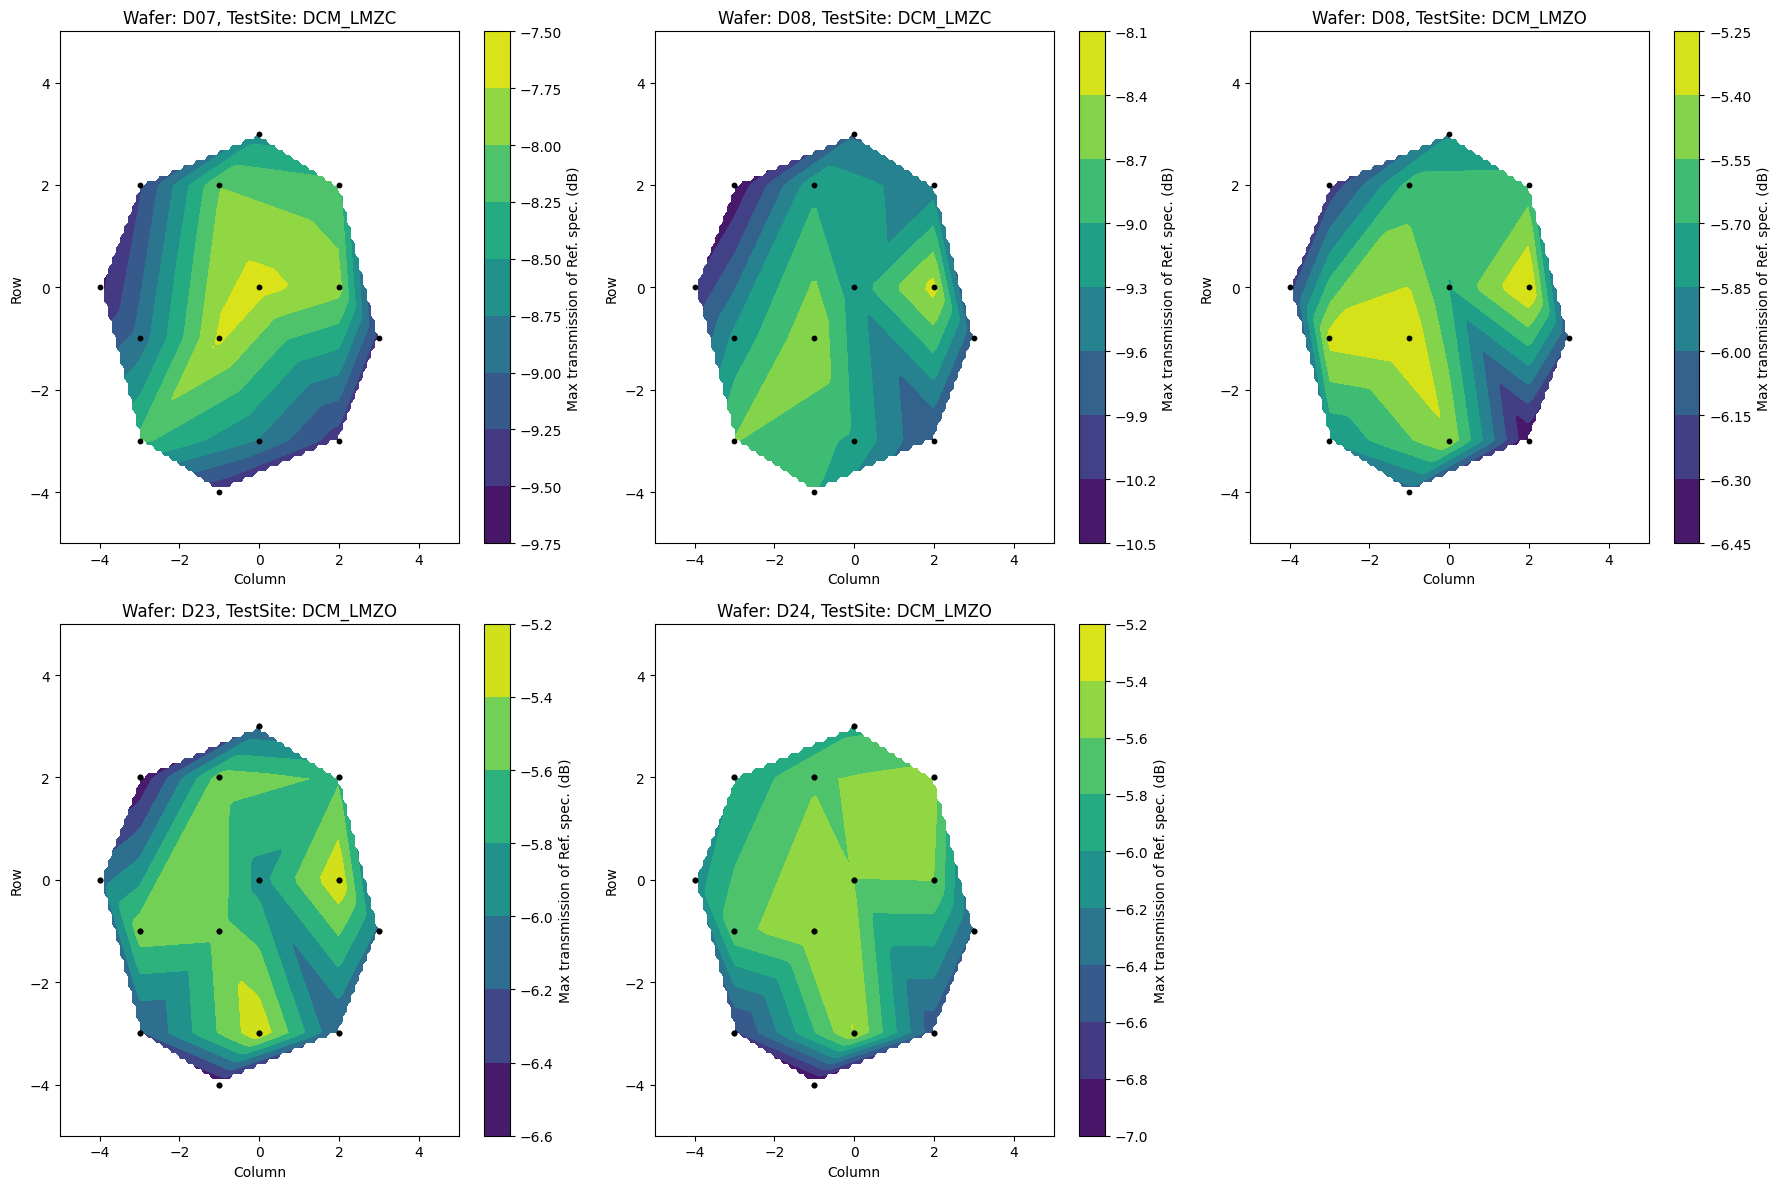

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# plz paste the path in the res pile
file_path = './needed/analysis_result_ex.xlsx'
df = pd.read_excel(file_path)

df.columns = [col.strip().replace(' ', '_').replace('.', '') for col in df.columns]

grouped = df.groupby(['Wafer', 'TestSite'])

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

for ax, ((wafer, testsite), group) in zip(axs[:-1], grouped):

    data = group[['Row', 'Column', 'Max_transmission_of_Ref_spec_(dB)']].dropna()

    x = data['Column']
    y = data['Row']
    z = data['Max_transmission_of_Ref_spec_(dB)']

    xi = np.linspace(-5, 5, 100)
    yi = np.linspace(-5, 5, 100)
    zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')


    contour = ax.contourf(xi, yi, zi, cmap='viridis')
    # cmap='viridis' or 'seismic' or 'plasma'

    ax.scatter(x, y, color='black', marker='o', s=10, label='Original Data Points')
    ax.set_title(f'Wafer: {wafer}, TestSite: {testsite}')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

    cbar = plt.colorbar(contour, ax=ax, orientation='vertical')
    cbar.set_label('Max transmission of Ref. spec. (dB)')

axs[-1].axis('off')

plt.tight_layout()
plt.show()


**This is a heatmap of the maximum transmission of the reference spectrum (Ref) grouped by wafer, testsite, and date.**

The last two graphs represent a single measurement session that was split due to passing dates during the measurement.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

file_path = './needed/analysis_result_ex.xlsx'
df = pd.read_excel(file_path)


df.columns = [col.strip().replace(' ', '_').replace('.', '') for col in df.columns]


df['Date'] = pd.to_datetime(df['Date']).dt.date


grouped = df.groupby(['Wafer', 'TestSite', 'Date'])


fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

for ax, ((wafer, testsite, date), group) in zip(axs, grouped):

    data = group[['Row', 'Column', 'Max_transmission_of_Ref_spec_(dB)']].dropna()


    x = data['Column']
    y = data['Row']
    z = data['Max_transmission_of_Ref_spec_(dB)']

    xi = np.linspace(-5, 5, 100)
    yi = np.linspace(-5, 5, 100)
    zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')


    contour = ax.contourf(xi, yi, zi, cmap='viridis')
    # cmap='viridis' or 'seismic' or 'plasma'

    ax.scatter(x, y, color='black', marker='o', s=10, label='Original Data')
    ax.set_title(f'Wafer: {wafer}, TestSite: {testsite}, Date: {date}')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')


    cbar = plt.colorbar(contour, ax=ax, orientation='vertical')
    cbar.set_label('Max transmission of Ref. spec. (dB)')


for ax in axs[len(grouped):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


---
## Error Flag Distribution per Wafer graph

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'analysis_result.xlsx'  # Change to the appropriate file path
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Rename columns to match the correct names
df = df.rename(columns={'Wafer': 'Wafer', 'ErrorFalg': 'ErrorFlag'})

# Extract Wafer and ErrorFlag columns
error_flags = df[['Wafer', 'ErrorFlag']]

# Count the number of ErrorFlags per wafer
error_flag_counts = error_flags.groupby(['Wafer', 'ErrorFlag']).size().unstack(fill_value=0).reset_index()

# Ensure all possible ErrorFlag values are present
for error_flag in [0, 1, 2]:
    if error_flag not in error_flag_counts.columns:
        error_flag_counts[error_flag] = 0

# Transform the DataFrame for easy plotting
error_flag_counts_melted = error_flag_counts.melt(id_vars='Wafer', var_name='ErrorFlag', value_name='Count')

# Create x-axis labels
error_flag_counts_melted['Wafer_ErrorFlag'] = error_flag_counts_melted['Wafer'] + ': ' + error_flag_counts_melted['ErrorFlag'].astype(str)

# Plotting the graph
fig, ax = plt.subplots(figsize=(10, 5))  # Reduce the size of the graph

# Plot the bar graph with different colors for each ErrorFlag
colors = {0: 'blue', 1: 'orange', 2: 'green'}
labels = {0: 'No Error', 1: 'Ref. spec. Error', 2: 'IV Error'}
for key, grp in error_flag_counts_melted.groupby('ErrorFlag'):
    ax.bar(grp['Wafer_ErrorFlag'], grp['Count'], color=colors[key], label=labels[key])

# Set graph title and axis labels
ax.set_title('Error Flag Distribution per Wafer')
ax.set_xlabel('Wafer: ErrorFlag')
ax.set_ylabel('Count of Error Flags')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add legend
plt.legend(title='Error Flags')

# Show the graph
plt.tight_layout()
plt.show()


![Error Flag Distribution per Wafer](needed/Error%20Flag%20Distribution%20per%20Wafer.png)

- As a result of analyzing the Error Flag, it was found that IV Error occurred in all data of D23 and D24 measured on May 31.

![Error Flag Distribution per Wafer](needed/Error%20Flag%20date.png)